<a href="https://colab.research.google.com/github/mylethidiem/zero-to-hero/blob/main/preAIO25/external/VisionTransformer_research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Vision Transformer**

In [ ]:
# Install packages
!pip install torchvision==0.16.0

In [ ]:
#
import torch
import torch.nn as nn
from torch.nn import functional as F

from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms

Nhằm đảm bảo tính đồng đều về kết quả của mô hình

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
def set_seed(seed):
  torch.manual_seed(seed)
SEED = 42
set_seed(SEED)

cuda


## LOAD DATA CIFAR10

What is [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html)?

- Đầu vào: 60.000 hình ảnh màu có kích thước (32x32) chia thành 10 lớp khác nhau đại diện cho máy bay, ô tô, chim, mèo, hươu, chó, ếch, ngựa, tàu thủy và xe tải. Dữ liệu được chia ra thành 50000 ảnh cho training và 10000 dùng để test. \
- Ở đây mình tiếp tục chia dữ liệu train ra làm 2 phần: 90% sẽ được dùng cho việc huấn luyện và 10% còn lại sẽ dùng cho bước validation.
- Số lượng batch size dùng hiện tại là 64 cho tập dữ liệu không phải là quá lớn
- Bước transformer(Biến đổi ảnh):
   - Các bức ảnh sẽ được resize về kích thước (224, 224) ?
   - Chuyển thành dữ liệu tensor cho việc tính toán
   - Chuẩn hóa


In [ ]:
batch_size = 64

# Why need transform??
transform =  transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #?
    ]
)

#download
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                             transform=transform, download=True)

# split data train into val and train
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            transform=transform, download=True)
train_subset_size = int(len(train_dataset) * 0.9)
val_subset_size = len(train_dataset) - train_subset_size
train_subset, val_subset = torch.utils.data.random_split(train_dataset, [train_subset_size,val_subset_size ])


# create dataloader contain batches of data to train(mini-batch)
train_loader = DataLoader(dataset=train_subset, batch_size=batch_size, shuffle=True, num_workers=2)#?
val_loader = DataLoader(dataset=val_subset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
print(f"Train size: {len(train_subset)}")
print(f"Train batches: {len(train_loader)}")
print(f"Validation size: {len(val_subset)}")
print(f"Test size: {len(test_dataset)}")

Files already downloaded and verified
Files already downloaded and verified
Train size: 45000
Train batches: 704
Validation size: 5000
Test size: 10000


## Build Model

### A little research (Các code trong mục này không được dùng cho model train dữ liệu bên dưới)

Linear Projection hay Linear Transformation: \
(Patch projection into Embedding)
- Có 2 cách: một là dùng lớp Convolution 2D như ví dụ bên dưới hoặc là dùng lớp Linear.
- Giải thích các tham số:
   - `in_channels` bằng 3 là số channel của một bức ảnh
   - `out_channels` số lượng embedding của mình mong muốn
   - `kernel_size=patch_size`: Để cho bức hình từ vector 3D thành vector 1D thì số kernel size nên để giá trị thành patch size để nó lấy hết cái hình.

In [ ]:
class PatchEmbedding(nn.Module):
  def __init__(self, embed_dim=512, patch_size=16, image_size=224):
    super().__init__()
    # 1 layer conv2d
    # image have 3 channels
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=embed_dim, kernel_size=patch_size, stride=patch_size, bias=False)

  def forward(self, x):
    x = self.conv1(x)

    # why we need reshape?
    print(f"x shape before reshape: {x.shape}") # shape [*, width, grid, grid]
    x = x.reshape(x.shape[0], x.shape[1], -1)
    print(f"x shape after reshape: {x.shape}") # shape [*, width, grid ** 2]

    # Hoán đổi vị trí 2 dữ liệu cuối sau khi đã reshape
    x.permute(0, 2, 1)
    return x


In [ ]:
# example
patch_embedding = PatchEmbedding()
x = torch.randn(1, 3, 224, 224)

out = patch_embedding(x)
print(out.shape)

x shape before reshape: torch.Size([1, 512, 14, 14])
x shape after reshape: torch.Size([1, 512, 196])
torch.Size([1, 512, 196])


Bước thêm thông tin về vị trí vào các vector embedding

In [ ]:
# Patch Positional Embedding
class PatchPositionalEmbedding(nn.Module):
  def __init__(self, embed_dim=512, patch_size=16, image_size=224):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=embed_dim, kernel_size=patch_size, stride=patch_size, bias=False)
    scale = embed_dim ** -0.5 #?
    print(embed_dim)
    data = scale * torch.randn((image_size // patch_size) ** 2, embed_dim)#?
    self.positional_embedding = nn.Parameter(data)

  def forward(self, x):
    x = self.conv1(x) # shape = [*, width, grid]
    x = x.reshape(x.shape[0], x.shape[1], -1) # shape = [*, width, grid ** 2]
    x = x.permute(0, 2, 1)  # shape = [*, grid ** 2, width]

    x = x + self.positional_embedding.to('cpu') #?
    return x


In [ ]:
patchpos_embedding = PatchPositionalEmbedding()
x = torch.randn(1, 3, 224, 224)

out = patchpos_embedding(x)
print(out.shape)

512
torch.Size([1, 196, 512])


### Build model

`PatchPostionalEmbeddingCLSToken` là một class tổng hợp cả 3 bước: \
 - Patch embedding
 - Positonal embedding
 - Add CLS token

In [ ]:
# Adding [CLS] token
class PatchPostionalEmbeddingCLSToken(nn.Module):
  def __init__(self, embed_dim=512, patch_size=16, image_size=224):
    super().__init__()

    self.conv1 = nn.Conv2d(in_channels=3, out_channels=embed_dim, kernel_size=patch_size, stride=patch_size, bias=False)

    scale = embed_dim ** -0.5

    data_class_embedding = scale * torch.randn(embed_dim)
    self.class_embedding = nn.Parameter(data_class_embedding)

    #
    data_positional_embedding = scale * torch.randn((image_size // patch_size) ** 2 + 1, embed_dim)
    self.positional_embedding = nn.Parameter(data_positional_embedding)

  def forward(self, x):
    x = self.conv1(x) # shape = [*, width, grid, grid]
    x = x.reshape(x.shape[0], x.shape[1], -1) # shape = [*, witdh, grid ** 2]
    x = x.permute(0, 2, 1) # shape = [*, grid ** 2, width]

    # expanding the CLS embedding
    cls_embs = self.class_embedding.to(x.dtype) + torch.zeros(x.shape[0], 1, x.shape[-1], dtype=x.dtype, device=x.device)
    x = torch.cat([cls_embs, x], dim=1) #shape = [*, grid ** 2 + 1, width]

    x = x + self.positional_embedding.to(x.dtype)
    return x


In [ ]:
# ex
patchpos_embedding = PatchPostionalEmbeddingCLSToken()
x = torch.randn(1, 3, 224, 224)
out = patchpos_embedding(x)
print(out.shape)

torch.Size([1, 197, 512])


Mô hình Transformer Encoder cho ảnh

In [ ]:
# class
class ViTTransformerEncoder(nn.Module):
  def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1) -> None:
    super().__init__()
    self.norm_1 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)
    self.attn = nn.MultiheadAttention(
        embed_dim=embed_dim,
        num_heads=num_heads,
        batch_first=True
    )
    self.norm_2 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)
    self.ffn = nn.Sequential(
        nn.Linear(in_features=embed_dim, out_features=ff_dim, bias=True),
        nn.GELU(),
        nn.Linear(in_features=ff_dim, out_features=embed_dim, bias=True)
    )
    self.dropout_1 = nn.Dropout(p=dropout)
    self.dropout_2 = nn.Dropout(p=dropout)

  def forward(self, x):
    # LayerNorm before Multi-Head Attention
    norm_x1 = self.norm_1(x)
    attn_output, _ = self.attn(norm_x1, norm_x1, norm_x1)
    attn_output = self.dropout_1(attn_output)
    x = x + attn_output # Residual connection

    # LayerNorm before Feed-Forward Network
    norm_x2 = self.norm_2(x)
    ffn_output = self.ffn(norm_x2)
    ffn_output = self.dropout_2(ffn_output)
    x = x + ffn_output # Residual connection

    return x

Mô hình Vision Transformer

In [ ]:
class VisionTransformerCLS(nn.Module):
  def __init__(self,
               image_size, embed_dim, num_heads, ff_dim,
               dropout=0.1, num_classes=10, patch_size=16) -> None:
    super().__init__()
    self.embed_layer = PatchPostionalEmbeddingCLSToken(
        image_size=image_size, embed_dim=embed_dim, patch_size=patch_size
    )
    self.transformer_layer = ViTTransformerEncoder(
        embed_dim, num_heads, ff_dim, dropout
    )
    why_20 = 20
    self.fc1 = nn.Linear(in_features=embed_dim, out_features=why_20)# why 20?
    self.fc2 = nn.Linear(in_features=why_20, out_features=num_classes)
    self.dropout = nn.Dropout(p=dropout)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.embed_layer(x)
    #Corrected to single input
    x = self.transformer_layer(x)
    x = x[:, 0, :]

    # Classification head
    x = self.dropout(x)
    x = self.fc1(x)
    x = self.relu(x) # Optional activation for fc1
    x = self.dropout(x)
    x = self.fc2(x)
    return x


In [ ]:
# ex
image_size = 224
embed_dim = 512
num_heads = 4
ff_dim = 128
dropout = 0.1

vit = VisionTransformerCLS(image_size, embed_dim, num_heads, ff_dim, dropout)

In [ ]:
#ex
x = torch.randn(1, 3, 224, 224)
out = vit(x) # call model to classify
print(out.shape)

torch.Size([1, 10])


## Training

In [ ]:
import torch.optim as optim

# Initialize model value
image_size = 224 # change to value 32, cause by cifar10 having image size 32 pixel
embed_dim = 512
num_heads = 4
ff_dim = 128
dropout = 0.1
learning_rate = 1e-5

model = VisionTransformerCLS(
    image_size, embed_dim, num_heads, ff_dim, dropout, num_classes=10
)
model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
import time

# train function
def train_epoch(model, optimizer, criterion, train_dataloader, device, epoch=0, log_interval=50):
  model.train()
  total_acc, total_count = 0, 0 # total
  losses = []
  start_time = time.time()

  for idx, (inputs, train_labels) in enumerate(train_dataloader):
    inputs, train_labels = inputs.to(device), train_labels.to(device)

    # reset gradient
    optimizer.zero_grad()

    # forward
    predictions = model(inputs)

    # loss
    loss = criterion(predictions, train_labels)
    losses.append(loss.item())

    # backward
    loss.backward()

    # update weight
    optimizer.step()

    # Calculate the number of correct predictions in the current batch
    #
    total_acc += (predictions.argmax(1) == train_labels).sum().item()
    # calculate train size
    total_count += train_labels.size(0) # len(train_labels)

    # print train for each epoch?...
    # log_interval = num_epochs?
    # idx =0,.. number of train loader(= train dataset / batch size) - 1
    if idx % log_interval == 0 and idx > 0:
      elapsed = time.time() - start_time
      print(
          "| epoch {:3d} | {:5d}/{:5d} batches "
          "| accuracy {:8.3f}".format(
              epoch, idx, len(train_dataloader), total_acc / total_count
          )
      )
      # total_acc, total_count = 0, 0 # why reset them?
      start_time = time.time()
  epoch_acc = total_acc / total_count # average accuracy loss
  epoch_loss = sum(losses) / len(losses) # average train loss
  return epoch_acc, epoch_loss


In [ ]:
#validation fucntion
def validation_epoch(model, criterion, val_dataloader, device):
  model.eval()
  total_acc, total_count = 0, 0
  losses = []

  # does not need call update gradient
  with torch.no_grad():
    for idx, (inputs, val_labels) in enumerate(val_dataloader):
      inputs, val_labels = inputs.to(device), val_labels.to(device)

      predictions = model(inputs)

      loss = criterion(predictions, val_labels)
      losses.append(loss.item())

      total_acc += (predictions.argmax(1) == val_labels).sum().item()
      total_count += val_labels.size(0)

  epoch_acc = total_acc / total_count
  epoch_loss = sum(losses) / len(losses)
  return epoch_acc, epoch_loss

In [ ]:
def train(model, model_name, save_model_path, optimizer, criterion, dataloader, num_epochs, device):
  """
  Usage: Train, validate model and save model
  dataloader = [train_dataloader, val_loader]
  """
  train_lost_list, train_acc_list = [], []
  val_lost_list, val_acc_list = [], []
  times = []
  best_loss_eval = 100
  train_loader, val_loader = dataloader[0], dataloader[1]
  for epoch in range(num_epochs):
    epoch_start_time = time.time()
    #train state
    train_acc, train_lost = train_epoch(model, optimizer, criterion, train_loader, device, epoch + 1, log_interval=int(len(train_loader) / 4))

    #validate state
    val_acc, val_lost = validation_epoch(model, criterion, val_loader, device)

    # save the best model
    if val_lost < best_loss_eval:
      torch.save(model.state_dict(), save_model_path + f'/{model_name}.pt')

    times.append(time.time() - epoch_start_time)

    # append value
    train_lost_list.append(train_lost)
    train_acc_list.append(train_acc)
    val_lost_list.append(val_lost)
    val_acc_list.append(val_acc)

    # print result for each epoch
    print("-" * 59)
    print(
        "| End of epoch {:3d} | Time: {:5.2f}s | Train Accuracy {:8.3f}  | Train Loss {:8.3f} "
        "| Validate Accuracy {:8.3f} | Validate Loss {:8.3f}".format(
            epoch + 1, time.time() - epoch_start_time, train_acc, train_lost, val_acc, val_lost
        )
    )
    print("-" * 59)
  # Load best model de lam gi?
  model.load_state_dict(torch.load(save_model_path + f'/{model_name}.pt'))
  model.eval()
  metrics = {
      'train_accuracy' : train_acc_list,
      'train_loss' : train_lost_list,
      'val_accuracy' : val_acc_list,
      'val_loss' : val_lost_list,
      'time' : times
  }
  return model, metrics

In [ ]:
import os
#input out put cua bai toan la gi, co the cai tien, kho khan cua bai toan la gi,
# co the cai tien bai toan nay hay khong?
# training and save model
num_epochs = 100
save_model_path = './model'
os.makedirs(save_model_path, exist_ok=True)
model_name = 'model_vit_cifar10'

dataloader = [train_loader, val_loader]
print(device)
model, metrics = train(
    model, model_name, save_model_path, optimizer, criterion, dataloader, num_epochs, device
)

cuda
| epoch   1 |   176/  704 batches | accuracy    0.598
| epoch   1 |   352/  704 batches | accuracy    0.599
| epoch   1 |   528/  704 batches | accuracy    0.602
-----------------------------------------------------------
| End of epoch   1 | Time: 47.81s | Train Accuracy    0.602  | Train Loss    1.119 | Validate Accuracy    0.597 | Validate Loss    1.113
-----------------------------------------------------------
| epoch   2 |   176/  704 batches | accuracy    0.605
| epoch   2 |   352/  704 batches | accuracy    0.602
| epoch   2 |   528/  704 batches | accuracy    0.602
-----------------------------------------------------------
| End of epoch   2 | Time: 48.06s | Train Accuracy    0.603  | Train Loss    1.115 | Validate Accuracy    0.591 | Validate Loss    1.127
-----------------------------------------------------------
| epoch   3 |   176/  704 batches | accuracy    0.605
| epoch   3 |   352/  704 batches | accuracy    0.604
| epoch   3 |   528/  704 batches | accuracy    0

## Visualization

In [ ]:
import matplotlib.pyplot as plt

def plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses):
  epochs = list(range(num_epochs))
  fig, axs = plt.subplots(nrows= 1, ncols=2, figsize=(12, 6))

  axs[0].plot(epochs, train_accs, label="Training", color='green')
  axs[0].plot(epochs, eval_accs, label="Evaluation", color='orange')
  axs[0].set(xlabel='Epoch', ylabel='Accuaracy')

  axs[1].plot(epochs, train_losses, label="Training", color='green')
  axs[1].plot(epochs, eval_losses, label="Evaluation", color='orange')
  axs[1].set(xlabel='Epoch', ylabel='Loss')
  plt.legend()


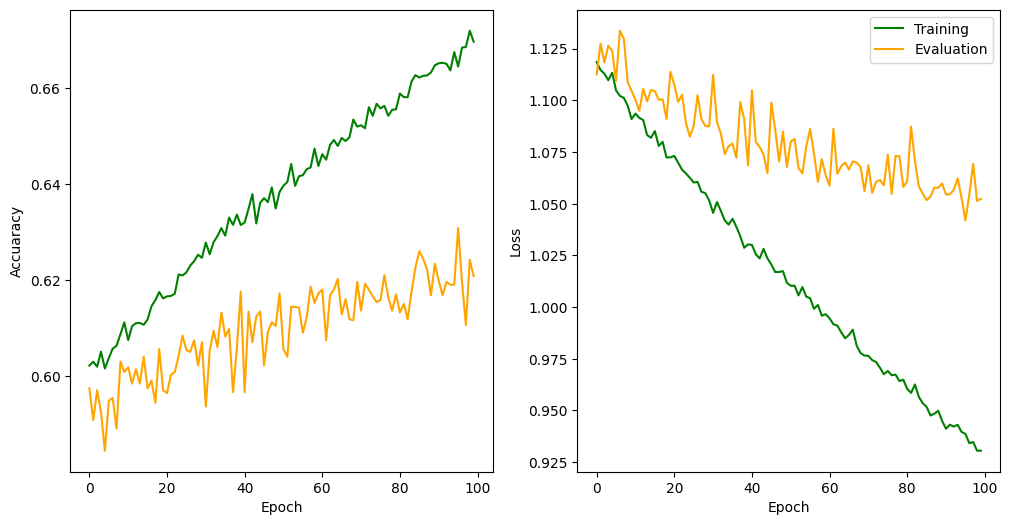

In [ ]:
# time = metrics["time"]
# print(f"Time: {time}")
plot_result(
    num_epochs,
    metrics["train_accuracy"],
    metrics["val_accuracy"],
    metrics["train_loss"],
    metrics["val_loss"]
)

## Evaluate by Test dataset

In [ ]:
test_target, test_predict = [], []
model.load_state_dict(torch.load(save_model_path + f'/{model_name}.pt'))
model.eval()
with torch.no_grad():
  for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    predictions = model(inputs)

    test_target.append(labels.cpu())
    test_predict.append(predictions.cpu())
test_target = torch.cat(test_target, dim=0)
test_predict = torch.cat(test_predict, dim=0)

test_acc = (torch.argmax(test_predict, dim=1)==test_target).sum().item() / len(test_target)
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.6208


# So sánh với CNN

[Link code](https://colab.research.google.com/drive/1dB36SwvVTZpXEUyPdEPe5w3CjS3BL0qw?usp=sharing#scrollTo=BhjF200mrbgd)

# Khó khăn:

1. Test Accuracy rất thấp: 0.5916 tương đương 59% với 50 epochs. Sau khi cải thiện bằng cách tăng số lượng epoch lên 100 epochs thì kết quả có tăng lên một chút là được khoảng 62% nhưng vẫn rất thấp so với mô hình CNN cho data này
2. Biểu đồ loss và accuracy qua 100 epochs nhìn không được ổn định lắm.


# Improve